# Prepare data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab 
from datetime import datetime, timedelta
import numpy as np
from fastai.collab import *
from fastai.tabular.all import *
from time import *

/home/nhat_pham/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Train and valid set

In [2]:
data = pd.read_csv(r'./charge_hourly_with_Covid.csv')

In [3]:
data

,Time,Energy_kWh,weekday,hour,hols,is_hol,R,IC_number,measure,E_1,E_2,E_3
0,2020-12-02 09:00:00,4.214567,2,9,NaN,False,1.21,30.0,1.00,NaN,NaN,NaN
1,2020-12-02 10:00:00,0.560625,2,10,NaN,False,1.21,30.0,1.00,4.214567,NaN,NaN
2,2020-12-02 11:00:00,0.000000,2,11,NaN,False,1.21,30.0,1.00,0.560625,4.214567,NaN
3,2020-12-02 12:00:00,0.000000,2,12,NaN,False,1.21,30.0,1.00,0.000000,0.560625,4.214567
4,2020-12-02 13:00:00,0.000558,2,13,NaN,False,1.21,30.0,1.00,0.000000,0.000000,0.560625
...,...,...,...,...,...,...,...,...,...,...,...,...
10211,2022-01-31 20:00:00,0.000000,0,20,NaN,False,0.96,20.0,0.25,0.000000,0.000000,0.000000
10212,2022-01-31 21:00:00,0.000000,0,21,NaN,False,0.96,20.0,0.25,0.000000,0.000000,0.000000
10213,2022-01-31 22:00:00,0.000000,0,22,NaN,False,0.96,20.0,0.25,0.000000,0.000000,0.000000
10214,2022-01-31 23:00:00,0.000000,0,23,NaN,False,0.96,20.0,0.25,0.000000,0.000000,0.000000


In [4]:
df = data.drop(['Time', 'hols'], axis=1)
df

,Energy_kWh,weekday,hour,is_hol,R,IC_number,measure,E_1,E_2,E_3
0,4.214567,2,9,False,1.21,30.0,1.00,NaN,NaN,NaN
1,0.560625,2,10,False,1.21,30.0,1.00,4.214567,NaN,NaN
2,0.000000,2,11,False,1.21,30.0,1.00,0.560625,4.214567,NaN
3,0.000000,2,12,False,1.21,30.0,1.00,0.000000,0.560625,4.214567
4,0.000558,2,13,False,1.21,30.0,1.00,0.000000,0.000000,0.560625
...,...,...,...,...,...,...,...,...,...,...
10211,0.000000,0,20,False,0.96,20.0,0.25,0.000000,0.000000,0.000000
10212,0.000000,0,21,False,0.96,20.0,0.25,0.000000,0.000000,0.000000
10213,0.000000,0,22,False,0.96,20.0,0.25,0.000000,0.000000,0.000000
10214,0.000000,0,23,False,0.96,20.0,0.25,0.000000,0.000000,0.000000


In [5]:
# Change the measure column to turn it into categorical data
df.loc[:, 'measure'] = df['measure']*4
df.loc[:, 'measure'] = df['measure'].astype(int)

In [6]:
df.drop(['E_2','E_3'], axis=1, inplace=True)
df.drop(['measure'], axis=1, inplace=True)
df = df.iloc[3:,:]

In [7]:
df

,Energy_kWh,weekday,hour,is_hol,R,IC_number,E_1
3,0.000000,2,12,False,1.21,30.0,0.000000
4,0.000558,2,13,False,1.21,30.0,0.000000
5,0.000000,2,14,False,1.21,30.0,0.000558
6,0.000000,2,15,False,1.21,30.0,0.000000
7,0.000000,2,16,False,1.21,30.0,0.000000
...,...,...,...,...,...,...,...
10211,0.000000,0,20,False,0.96,20.0,0.000000
10212,0.000000,0,21,False,0.96,20.0,0.000000
10213,0.000000,0,22,False,0.96,20.0,0.000000
10214,0.000000,0,23,False,0.96,20.0,0.000000


In [8]:
cont_df,cat_df = cont_cat_split(df, max_card = 25, dep_var = 'Energy_kWh')

In [9]:
cat_df

['weekday', 'hour', 'is_hol']

In [10]:
cont_df

['R', 'IC_number', 'E_1']

In [11]:
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(0.2)(range_of(df))
to_dt = TabularPandas(df, procs_nn, cat_df, cont_df, splits=splits, y_names='Energy_kWh')

In [12]:
xs,y = to_dt.train.xs, to_dt.train.y
valid_xs, valid_y = to_dt.valid.xs, to_dt.valid.y

## Test set

In [13]:
data_test = pd.read_csv(r'./charge0322_hourly_with_Covid.csv')

In [14]:
df_test = data_test.drop(['Time', 'hols'], axis=1)

In [15]:
# Change the measure column to turn it into categorical data
df_test.loc[:, 'measure'] = df_test['measure']*4
df_test.loc[:, 'measure'] = df_test['measure'].astype(int)

df_test.loc[:, 'measure'] = 0

df_test.drop(['E_2','E_3'], axis=1, inplace=True)
#df_test.drop(['E_1'], axis=1, inplace=True)
#df_test.drop(['E_3'], axis=1, inplace=True)
df_test.drop(['measure'], axis=1, inplace=True)
df_test

,Energy_kWh,weekday,hour,is_hol,R,IC_number,E_1
0,20.373633,1,8,False,0.930,15.0,13.420700
1,13.782533,1,9,False,0.930,15.0,20.373633
2,6.048033,1,10,False,0.930,15.0,13.782533
3,11.972108,1,11,False,0.930,15.0,6.048033
4,7.439792,1,12,False,0.930,15.0,11.972108
...,...,...,...,...,...,...,...
660,0.000000,0,20,True,1.265,10.0,0.000000
661,0.000000,0,21,True,1.265,10.0,0.000000
662,0.000000,0,22,True,1.265,10.0,0.000000
663,0.000000,0,23,True,1.265,10.0,0.000000


In [16]:
cont_df_test,cat_df_test = cont_cat_split(df_test, max_card = 25, dep_var = 'Energy_kWh')

In [17]:
cat_df_test

['weekday', 'hour', 'is_hol']

In [18]:
rocs_nn = [Categorify, Normalize]
to_test = TabularPandas(df_test, procs_nn, cat_df_test, cont_df_test, y_names='Energy_kWh')

In [19]:
test_xs,test_y = to_test.train.xs, to_test.train.y

# Tree regression with sklearn

In [20]:
from sklearn import tree

m = tree.DecisionTreeRegressor(min_samples_leaf=28)
m.fit(xs,y)

DecisionTreeRegressor(min_samples_leaf=28)

In [21]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [22]:
m_rmse(m, xs, y)

1.697096

In [23]:
m_rmse(m, valid_xs, valid_y)

1.745598

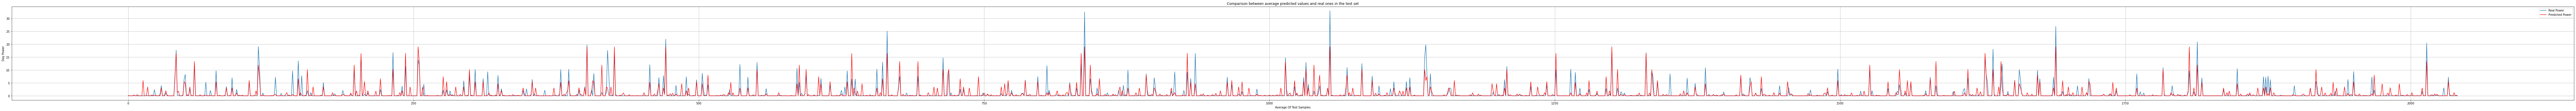

In [24]:
plt.figure(figsize=(160,6))
plt.plot(range(len(valid_y)), valid_y)
plt.plot(range(len(m.predict(valid_xs))), m.predict(valid_xs), 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.grid()
plt.show()

In [25]:
m_rmse(m, test_xs, test_y)

3.521366

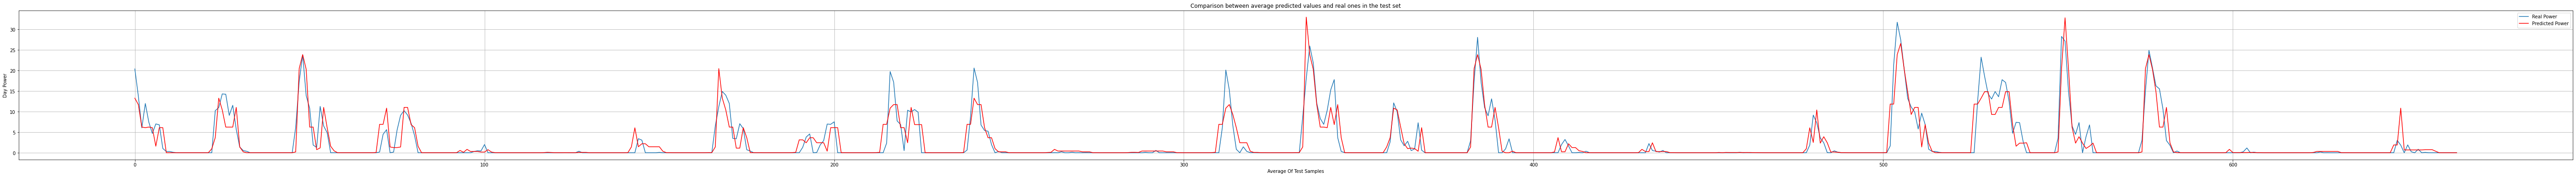

In [26]:
plt.figure(figsize=(100,6))
plt.plot(range(len(test_y)), test_y)
plt.plot(range(len(test_xs)), 2*m.predict(test_xs), 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.grid()
plt.show()

# Random forest with fastai

In [27]:
from sklearn import ensemble

def rf(xs, y, n_estimators=100, max_samples=500, max_features=0.5, min_samples_leaf=5, **kwargs):
    return ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples,
                                max_features=max_features, min_samples_leaf=min_samples_leaf,
                                oob_score=True).fit(xs, y)

In [28]:
trees = rf(xs, y)

In [29]:
m_rmse(trees, xs, y)

1.90411

In [30]:
m_rmse(trees, valid_xs, valid_y)

1.833128

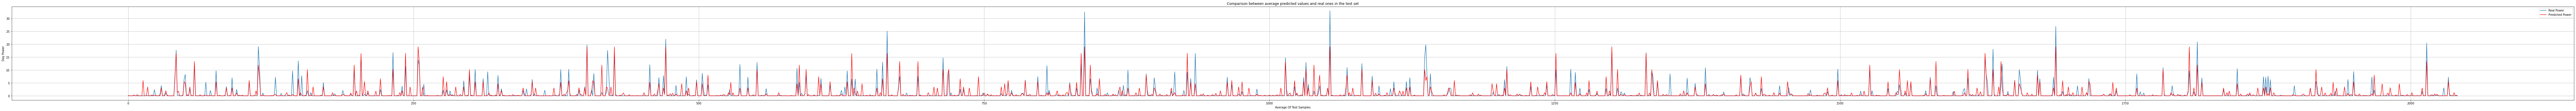

In [31]:
plt.figure(figsize=(160,6))
plt.plot(range(len(valid_y)), valid_y)
plt.plot(range(len(m.predict(valid_xs))), m.predict(valid_xs), 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.grid()
plt.show()

In [32]:
m_rmse(m, test_xs, test_y)

3.521366

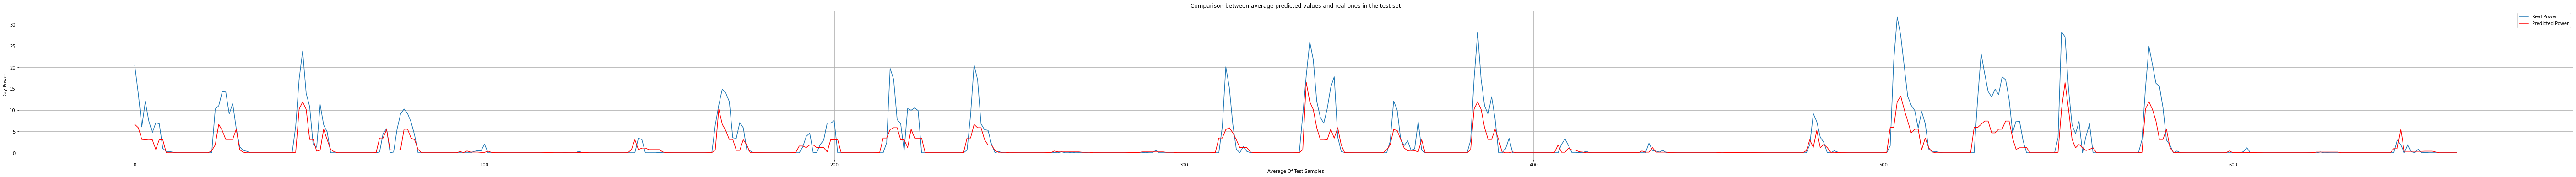

In [33]:
plt.figure(figsize=(100,6))
plt.plot(range(len(test_y)), test_y)
plt.plot(range(len(test_xs)), m.predict(test_xs), 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.grid()
plt.show()